In [38]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
def load_and_preprocess_images(directory, image_size=(224, 224)):
    images = []
    labels = []
    paths = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                img_path = os.path.join(subdir, file)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    image = image / 255.0  # Normalize
                    images.append(image)
                    labels.append(subdir.split(os.sep)[-2])  # Use the parent directory as label
                    paths.append(img_path)
    return np.array(images), labels, paths

# Load images from the provided dataset directory
dataset_dir = 'train'
images, labels, image_paths = load_and_preprocess_images(dataset_dir)
print(f"Loaded {len(images)} images from the dataset.")

Loaded 201 images from the dataset.


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Prepare data for training
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Create and compile the model
input_shape = (224, 224, 3)
num_classes = len(np.unique(labels))
cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 623ms/step - accuracy: 0.4975 - loss: 3.3450 - val_accuracy: 0.4878 - val_loss: 0.6700
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.7256 - loss: 0.5335 - val_accuracy: 0.6341 - val_loss: 0.5943
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step - accuracy: 0.8256 - loss: 0.3312 - val_accuracy: 0.9268 - val_loss: 0.4299
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - accuracy: 0.9609 - loss: 0.1489 - val_accuracy: 0.8780 - val_loss: 0.3485
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 599ms/step - accuracy: 0.9817 - loss: 0.0709 - val_accuracy: 0.9512 - val_loss: 0.3426
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - accuracy: 0.9850 - loss: 0.0357 - val_accuracy: 0.9268 - val_loss: 0.2046
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.9979 - loss: 0.0123 - val_accuracy: 0.9512 - val_loss: 0.2663
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9512 - val_loss:

In [41]:
# Ensure the model is built by calling it with some input data
cnn_model.predict(np.expand_dims(images[0], axis=0))

# Create a model to extract features from the penultimate layer
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# Extract features for the entire dataset
features = feature_extractor.predict(images)
print(f"Extracted features for {len(features)} images.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
Extracted features for 201 images.


In [55]:
def find_similar_images(input_image_path, model, features, image_paths, top_n=10):
    input_image = cv2.imread(input_image_path)
    input_image = cv2.resize(input_image, (224, 224)) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
    
    input_features = model.predict(input_image)
    
    similarities = cosine_similarity(input_features, features)
    similar_indices = np.argsort(similarities[0])[::-1][:top_n]
    
    similar_images = [image_paths[idx] for idx in similar_indices]
    return similar_images

# Example usage
input_image_path = 'test-pic4.jpg'
similar_images = find_similar_images(input_image_path, feature_extractor, features, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


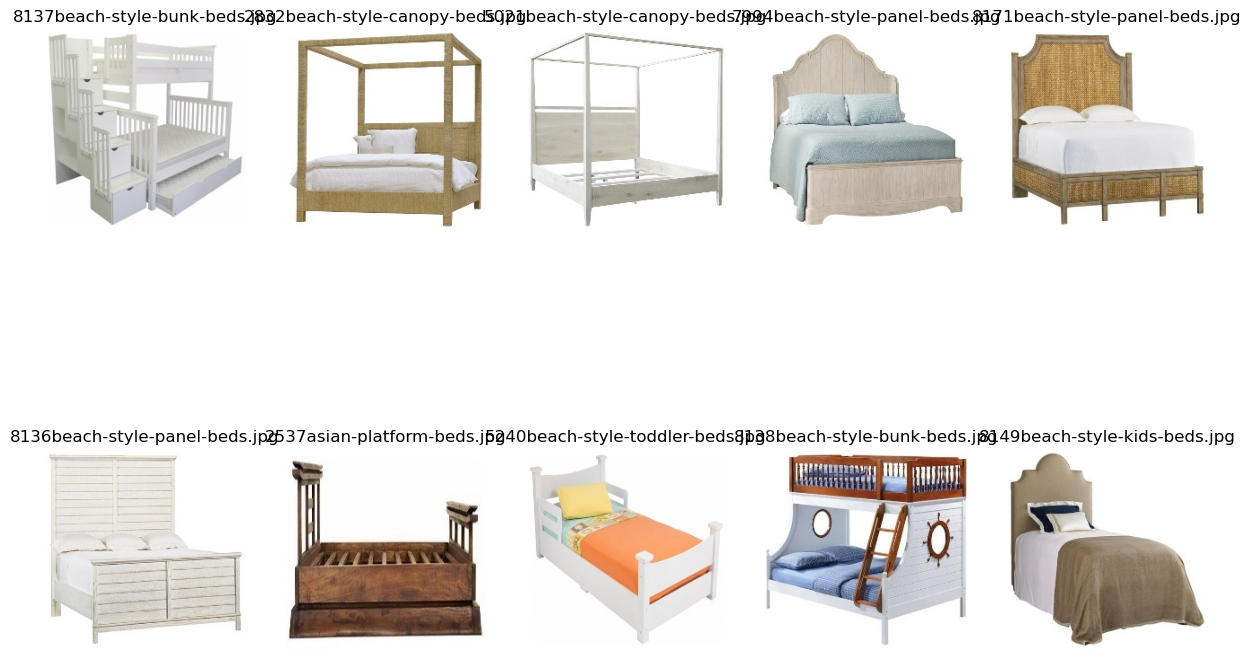

In [56]:
def display_images(image_paths):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    plt.show()

# Display similar images
display_images(similar_images)
